In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('sab-bma.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9735,AGGCTAACGCCTTTATTATATAACCACTCTTAGCCCATAGGACTAC...,AGGCCTAACGCCTTTATTATATAACCACTCTTAGCCCATAGGACTA...
9736,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGATATGGGCCC...
9737,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9738,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 9740/9740 [00:00<00:00, 63165.47it/s]


[62, 69, 113, 132, 159, 195, 223, 266, 286, 304, 343, 354, 411, 439, 472, 517, 546, 567, 621, 656, 704, 725, 744, 802, 860, 898, 912, 952, 1011, 1050, 1091, 1107, 1152, 1201, 1250, 1259, 1353, 1341, 1382, 1404, 1431, 1517, 1545, 1539, 1647, 1657, 1687, 1715, 1771, 1839, 1907, 1888, 1913, 1950, 2036, 2229, 2198, 2150, 2081, 2074, 2038, 1998, 1943, 1899, 1871, 1852, 1723, 1743, 1702, 1638, 1615, 1609, 1519, 1497, 1417, 1410, 1358, 1308, 1271, 1230, 1218, 1168, 1151, 1049, 1045, 953, 921, 868, 854, 818, 754, 683, 685, 580, 585, 542, 500, 453, 429, 402, 353, 320, 290, 248, 223, 189, 155, 136, 77, 64]


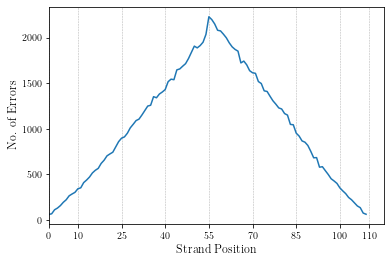

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.xlabel(r'Strand Position', fontsize=12)
plt.ylabel(r'No. of Errors', fontsize=12)
plt.grid(axis = 'x', linestyle='--', linewidth = 0.5)
plt.xlim(0, 115)
plt.xticks([0, 10, 25, 40, 55, 70, 85, 100, 110])
plt.show()
f.savefig('cov5-sab-bma-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 9740/9740 [00:06<00:00, 1598.28it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


GGA ->  6
C -> TT 6
GGC ->  6
C -> AT 6
 -> GTA 6
 -> ACAC 6
CCG ->  6
 -> TAA 6
T -> CGC 6
AG -> C 6
TCC ->  6
TT -> CC 6
 -> ATC 6
 -> ATG 6
TG -> AC 6
 -> TCC 6
TGA ->  7
GT -> CC 7
GG -> CA 7
 -> CCG 7
 -> TAG 7
C -> GA 7
TAG ->  7
GGG ->  7
 -> AAT 7
TAC ->  7
T -> CAC 7
TA -> C 7
 -> ACT 7
CG -> T 8
TGC ->  8
TTT ->  8
 -> GTT 8
GT -> CA 8
CTC ->  8
GCT ->  8
G -> ACA 8
GAT ->  8
 -> GCG 8
G -> AT 8
 -> GGA 8
 -> CGA 8
AGG ->  8
CA -> G 8
C -> AG 9
TTC ->  9
GG -> C 9
TT -> AC 9
TG -> CC 9
TGT ->  9
CCT ->  9
AGT ->  9
TCT ->  9
CT -> AG 9
 -> CTC 9
GTA ->  9
 -> GAC 9
 -> CAC 9
GTC ->  9
 -> TAC 9
 -> CAT 9
 -> CCC 9
 -> TCA 9
 -> CAG 10
CC -> T 10
TT -> GC 10
TGG ->  10
CT -> G 10
GTT ->  10
T -> CG 10
AGC ->  10
CC -> A 10
GTG ->  10
CT -> AA 10
CGG ->  10
GGT ->  11
 -> CGC 11
TCG ->  11
 -> TTT 11
 -> ACG 11
 -> AGC 11
C -> AA 11
GG -> AC 11
CGT ->  12
 -> GAG 12
AT -> G 12
CTG ->  12
 -> ACA 12
G -> CA 12
ATT ->  13
GG -> AA 13
TT -> G 13
CG -> AA 13
CTT ->  13
TC -> AA 13


 -> C @ 63 6
G ->  @ 104 6
G ->  @ 107 6
T ->  @ 11 6
 -> A @ 36 6
 -> C @ 68 6
 -> C @ 51 6
 -> C @ 47 6
G ->  @ 11 6
A ->  @ 61 6
C ->  @ 35 6
T ->  @ 106 6
C -> A @ 47 6
T -> A @ 35 6
C -> A @ 50 6
 -> C @ 41 6
A -> C @ 82 6
 -> C @ 34 6
 -> C @ 35 6
 -> A @ 49 6
A ->  @ 64 6
 -> C @ 40 6
 -> C @ 43 6
 -> A @ 62 6
T -> C @ 31 6
T -> C @ 45 6
C -> A @ 59 6
TG ->  @ 59 6
C ->  @ 79 6
C -> A @ 68 6
C ->  @ 84 6
C -> A @ 69 6
T -> C @ 20 6
G -> A @ 44 6
 -> A @ 97 6
T ->  @ 7 6
C -> A @ 79 6
GT ->  @ 57 6
G -> A @ 102 6
 -> GC @ 56 6
G -> A @ 22 6
G -> A @ 21 6
T -> C @ 11 6
G -> A @ 19 6
C -> A @ 25 6
C ->  @ 77 6
T ->  @ 28 6
T ->  @ 27 6
A ->  @ 88 6
T ->  @ 12 6
T -> A @ 25 6
C ->  @ 41 6
G -> A @ 95 6
G -> A @ 94 6
C -> T @ 34 6
T -> G @ 56 6
T ->  @ 16 6
 -> C @ 106 6
 -> AG @ 53 6
G -> A @ 87 6
G -> A @ 86 6
 -> C @ 1 6
G -> A @ 84 6
C ->  @ 6 6
C -> A @ 51 6
C ->  @ 60 6
C ->  @ 64 6
T -> C @ 52 6
T -> A @ 84 6
 -> G @ 66 6
 -> TA @ 54 6
T -> A @ 47 6
 -> TT @ 57 6
 -> A @ 28 6


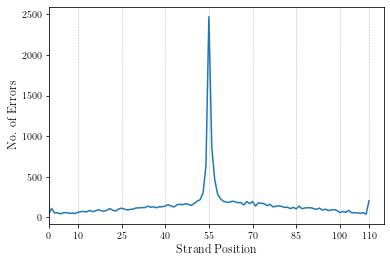

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.xlabel(r'Strand Position', fontsize=12)
plt.ylabel(r'No. of Errors', fontsize=12)
plt.grid(axis = 'x', linestyle='--', linewidth = 0.5)
plt.xlim(0, 115)
plt.xticks([0, 10, 25, 40, 55, 70, 85, 100, 110])
plt.show()
f.savefig('cov5-sab-bma-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 12, 9, 7, 10, 14, 18, 11, 14, 5, 9, 6, 18, 11, 15, 11, 15, 16, 8, 12, 8, 17, 18, 10, 13, 10, 12, 7, 7, 14, 15, 18, 17, 12, 12, 14, 22, 11, 16, 18, 14, 24, 17, 14, 17, 17, 18, 18, 15, 11, 13, 15, 13, 17, 30, 62, 64, 24, 19, 17, 19, 17, 8, 17, 11, 28, 16, 9, 13, 14, 10, 8, 20, 12, 18, 10, 9, 10, 15, 11, 11, 16, 8, 8, 11, 9, 16, 14, 14, 12, 8, 14, 10, 14, 15, 10, 11, 19, 11, 11, 10, 11, 5, 21, 6, 10, 10, 6, 9, 9, 109]
[0, 19, 1, 7, 9, 5, 5, 6, 2, 4, 8, 6, 6, 2, 11, 8, 6, 9, 8, 4, 16, 9, 7, 14, 12, 12, 5, 6, 6, 10, 11, 5, 12, 10, 12, 8, 14, 15, 9, 6, 16, 11, 14, 11, 11, 11, 12, 15, 16, 12, 9, 22, 15, 14, 37, 61, 73, 31, 21, 16, 16, 14, 18, 23, 13, 14, 12, 7, 15, 15, 15, 13, 11, 9, 17, 8, 16, 8, 10, 17, 5, 7, 2, 7, 12, 8, 10, 8, 11, 14, 14, 10, 11, 18, 10, 14, 4, 13, 14, 9, 9, 11, 7, 11, 8, 12, 6, 9, 13, 14, 9]
[10, 1, 7, 3, 4, 1, 4, 7, 2, 2, 4, 5, 3, 3, 5, 5, 7, 5, 5, 5, 9, 7, 3, 7, 0, 8, 4, 8, 6, 5, 9, 5, 5, 7, 7, 9, 6, 2, 4, 10, 9, 8, 8, 9, 10, 10, 4, 15, 9, 6, 14, 5, 19, 25, 75, 365

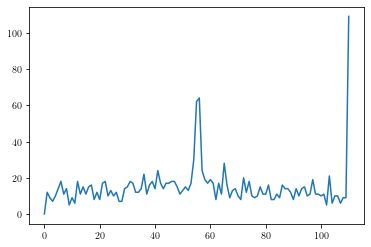

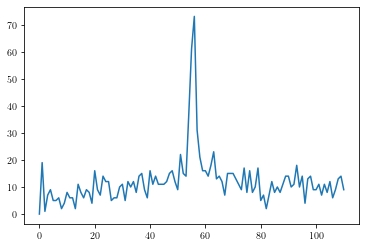

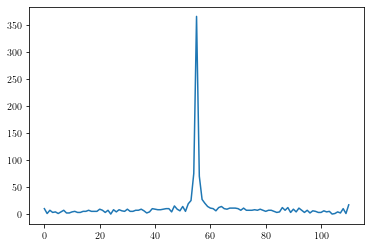

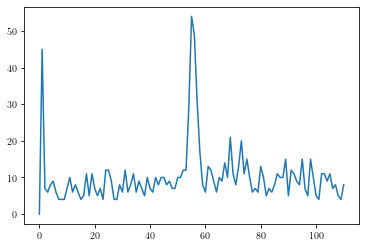

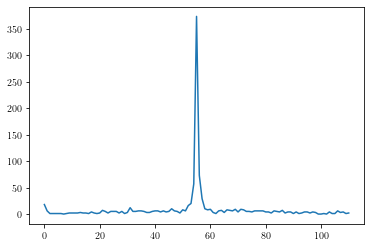

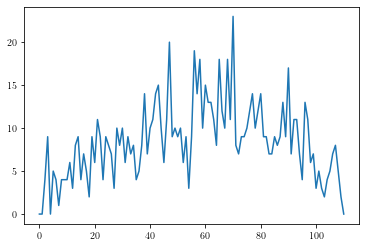

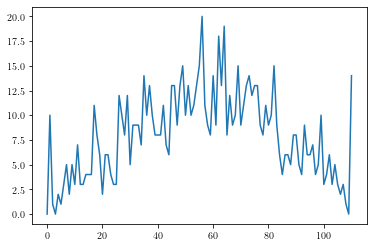

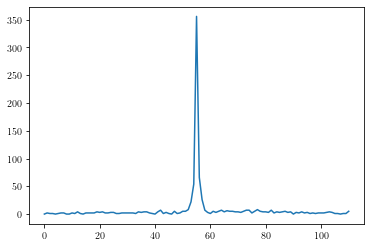

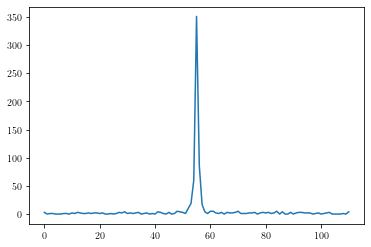

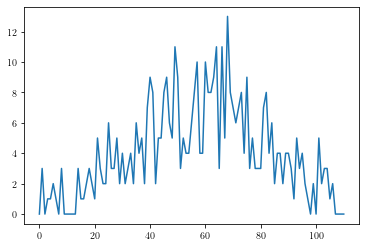

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)